In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

### Константы

In [2]:
exp = np.exp(1)
px = 1145 #кг/м3
K=2.362
e=0.624
POE=0.0194 #кг/кг
d=0.0018 #м
Cnn=5.7 #г/л
Cnk=0.3 #г/л
Hc=0.25 #м
ayr=1
byr=3.362
Dy=1.68e-9
De=0.077
pnas=460
Vob=10 #м3/ч
Vstok = 1000 #м3
Ck=0.3177 #г-экв|л
Cn=31.77 #г-экв|л
GHcl = 18.4 #л
dmin4=0.0012 #м

Предварительные расчёты (не зависят от диаметра колонны).

In [3]:
Ar=(d**3)*1000*(px-1000)*9.81/(0.001*0.001) #Архимед фиктивный 0,001 и 1000 это вязкость и плотность воды
Re=(Ar*e**4.75)/(18 + 0.61 * (np.sqrt(Ar*e**4.75))) #Рейнольдс фиктивный
w=Re*0.001/d/1000 #скорость факт
D=np.sqrt(Vob/(3600*0.785*w)) #диаметр аппарата, его стоит изменить
Armin=(dmin4**3)*1000*(px-1000)*9.81/(0.001*0.001) #минимальный критерий архимеда
wun=Armin / (18+0.61*(Armin**0.5))*(0.001/(dmin4*1000)) #скорость уноса частицы
Reun=d*wun*1000/0.001 #Рейнольдс уноса

### Формулы

In [4]:
# Функция расчёта переменных по заданному диаметру колонны Dist

def calculate_column(Dist):

    wf=Vob/(3600*0.785*Dist*Dist) #фактическая скорость при диаметре
    Ref=wf*d*1000/0.001 #фактический рейнольдс
    eun=((18*Reun+0.36*Reun*Reun)/Ar)**0.21 #фактическая порозность
    ef=((18*Ref+0.36*Ref*Ref)/Ar)**0.21 #порозность для уточненного значения Re
    Hyn=0.25*(1-ef)/(1-eun)
    Hist=Hyn*1.3
    Pr=0.001/1000/Dy #Прандль
    Nu=2+(1.5*(Pr**0.33))*((1-ef)*Ref)**0.5 #Нуссельт
    bc=Nu*Dy/d #коэффициент внешней массоотдачи
    Ccp=(Cnn-Cnk)/np.log((Cnn/Cnk)) #среднее
    Xcp=(Ccp*Cnn)/(K*POE+K*Ccp+Ccp) # КОнцентрация ионов Cu2+ в смоле находящейся в равновесии с жидкостью
    GG=Xcp/Ccp #тангенс угла наклона равновесной линии
    Bi=bc*(d/2)/(px*(De/1000000000)*GG) #критерий Био
    Xn=(Cnn*Cnn)/(K*POE+K*Cnn+Cnn) #начальная концентрация на 1-ую тарелку, кг/кг
    Gmin=Vob * (Cnn-Cnk)/Xn #минимальный расход адсорбента Cnn и Cnk концентрации в г/л
    Gnorm=Gmin*1.3 #поправка на мин расход адсорбента
    Xk=Vob * (Cnn-Cnk)/Gnorm #конечная концентрация на ступени
    Vc=0.785*Dist*Dist*Hc #объем псевдоожиженного слоя на тарелке
    bx=10*(De/1000000000)*pnas*Xn/(d*(1-ef)*Cnn) #коэффициент массоотдачи в адсорбенте
    Ky=1/(1/bc+1/bx) #коэффициент массопередачи
    bprod=0.0567*(wf/(1-ef))*((1000*wf*d/0.001)**0.22) #коэффициент продольного перемешивания
    Kyy=1/(1/Ky+1/bprod) #поправка Ky на продольное перемешивание
    a=6*(1-ef)/d #удельная поверхность адсорбента
    Kist=a*Kyy #коэффициент массопередачи со всеми поправками
    A=exp**(Vc*Kist*3600/Vob) #константа для уравнения расчета тарелок
    tcp=((d/2)*GG*px*Xk/Xcp)/(3*bc*(1-Xk/Xcp)) #среднее время пребывания частиц ионита в аппарате 
    tcph = tcp/3600
    
    #Расчёт тарелок
    n = 2
    conc=Cnn/A+((Xk*(A-1))/(A*(ayr-Xk*byr)))
    Csumm=n
    while conc > Cnk:
        conc = (conc/A)+(((Vob/Gnorm)*(conc-Cnn)+Xk)*(A-1))/(A*(ayr+(byr*Vob/Gnorm)*(Cnn-conc)-Xk*byr))
        Csumm = n
        n += 1
        if n > 40:
            break
    
    conc = np.clip(conc, 0, Cnn)
    L=Hist*Csumm # общая высота колонны
    hd = L/Dist # высота к диаметру
    Pnag=0.53 #МПа
    dPcyx=1.65*1000*wf*wf/2/1000000 #перепад давления на сухой тарелке
    dPsloy=(px-1000)*(1-ef)*Hyn/1000000 #перепад давления в слое
    Pstol=1000*9.81*L/1000000 #давления столба жидкости
    Pitog=dPcyx+dPsloy+Pstol+Pnag #общее давление
    S=(2*Dist*1000)/(2*355*1-Pitog) #толщина стенки
    Sobs=S+S*2+2 #тощина с прибавкой на коррозию, где S*2 это она
    Sdno=8 #определенная по ГОСТ 6533-78
    MassO=(3.14/4)*(((Dist+Sobs/1000)**2)-Dist**2)*L*7800 #7800 плотность стали нерж, масса цилиндра
    MassD=(3.14/6)*(((Dist+Sobs/1000)**2)-Dist**2)*7800 #масса днища
    MassOp=(3.14/4)*(((Dist+Sobs/1000)**2)-Dist**2)*7800
    MassDet=MassO*0.1 #масса сварных деталей
    OmsM=MassO+MassD+MassOp+MassDet #масса общая, кг
    Stoim=OmsM*2.357/1000 #стоимость млн руб аппарата
    
    # Выбор переменных для вывода
    
    cols = [Dist, wf, Ref, eun, ef, Hyn, Hist, Pr, Nu, bc, Ccp, Xcp, GG, Bi, Xn, Gmin, Gnorm,
    Xk, Vc, bx, Ky, bprod, Kyy, a, Kist, A, tcp, tcph, L, hd, Csumm, Pnag, dPcyx, dPsloy, 
    Pstol, Pitog, S, Sobs, Sdno, MassO, MassD, MassOp, MassDet, OmsM, Stoim, conc]
    
     
    
    return cols

In [5]:
data = []

D_list = np.arange(.5, 1.2, .1)
for Dist in D_list:
    cols = calculate_column(Dist)
    data.append(cols)

# data = np.round(np.array(data), decimals=4)

## Таблица всех переменных расчёта по различным диаметрам $Dist$

(Константы и переменные из предварительного расчёта в таблицу не включены)

In [6]:
all_names = ['Dist', 'wf', 'Ref', 'eun', 'ef', 'Hyn', 'Hist', 'Pr', 'Nu', 'bc', 'Ccp', 'Xcp', 'GG', 'Bi', 'Xn', 'Gmin', 'Gnorm',
    'Xk', 'Vc', 'bx', 'Ky', 'bprod', 'Kyy', 'a', 'Kist', 'A', 'tcp', 'tcph', 'L', 'hd', 'Csumm', 'Pnag', 'dPcyx', 'dPsloy', 
    'Pstol', 'Pitog', 'S', 'Sobs', 'Sdno', 'MassO', 'MassD', 'MassOp', 'MassDet', 'OmsM', 'Stoim', 'conc']

df = pd.DataFrame(data, columns=all_names)
df

,Dist,wf,Ref,eun,ef,Hyn,Hist,Pr,Nu,bc,Ccp,Xcp,GG,Bi,Xn,Gmin,Gnorm,Xk,Vc,bx,Ky,bprod,Kyy,a,Kist,A,tcp,tcph,L,hd,Csumm,Pnag,dPcyx,dPsloy,Pstol,Pitog,S,Sobs,Sdno,MassO,MassD,MassOp,MassDet,OmsM,Stoim,conc
0,0.5,0.014,25.478,0.833,0.594,0.609,0.792,595.238,41.746,3.896e-05,1.834,1.683,0.918,0.433,1.691,31.927,41.505,1.301,0.049,1.437e-04,3.065e-05,4.026e-03,3.042e-05,1354.640,0.041,2.071,27564.191,7.657,3.958,7.917,5,0.53,1.653e-07,3.588e-05,0.039,0.569,1.410,6.229,8,151.904,25.584,38.376,15.190,231.054,0.545,0.158
1,0.6,0.010,17.693,0.833,0.537,0.693,0.901,595.238,37.337,3.485e-05,1.834,1.683,0.918,0.388,1.691,31.927,41.505,1.301,0.071,1.262e-04,2.731e-05,2.267e-03,2.698e-05,1541.926,0.042,2.881,30819.001,8.561,1.802,3.004,2,0.53,7.971e-08,4.649e-05,0.018,0.548,1.691,7.074,8,94.230,34.857,52.286,9.423,190.796,0.450,0.000
2,0.7,0.007,12.999,0.833,0.496,0.755,0.981,595.238,33.610,3.137e-05,1.834,1.683,0.918,0.349,1.691,31.927,41.505,1.301,0.096,1.159e-04,2.469e-05,1.429e-03,2.427e-05,1679.383,0.041,4.100,34236.399,9.510,2.944,4.206,3,0.53,4.302e-08,5.515e-05,0.029,0.559,1.973,7.920,8,201.030,45.518,68.277,20.103,334.928,0.789,0.266
3,0.8,0.006,9.952,0.833,0.464,0.803,1.044,595.238,30.522,2.849e-05,1.834,1.683,0.918,0.317,1.691,31.927,41.505,1.301,0.126,1.090e-04,2.258e-05,9.701e-04,2.207e-05,1785.781,0.039,5.942,37700.855,10.472,2.087,2.609,2,0.53,2.522e-08,6.236e-05,0.020,0.551,2.255,8.766,8,180.227,57.565,86.347,18.023,342.162,0.806,0.201
4,0.9,0.004,7.863,0.833,0.439,0.841,1.094,595.238,27.953,2.609e-05,1.834,1.683,0.918,0.290,1.691,31.927,41.505,1.301,0.159,1.040e-04,2.086e-05,6.945e-04,2.025e-05,1871.402,0.038,8.746,41164.906,11.435,2.187,2.430,2,0.53,1.574e-08,6.848e-05,0.021,0.552,2.537,9.612,8,232.945,70.999,106.498,23.294,433.737,1.022,0.038
5,1.0,0.004,6.369,0.833,0.417,0.873,1.135,595.238,25.797,2.408e-05,1.834,1.683,0.918,0.268,1.691,31.927,41.505,1.301,0.196,1.002e-04,1.941e-05,5.174e-04,1.871e-05,1942.346,0.036,13.034,44606.458,12.391,2.270,2.270,2,0.53,1.033e-08,7.378e-05,0.022,0.552,2.819,10.457,8,292.246,85.820,128.729,29.225,536.019,1.263,0.081
6,1.1,0.003,5.264,0.833,0.399,0.900,1.170,595.238,23.965,2.237e-05,1.834,1.683,0.918,0.249,1.691,31.927,41.505,1.301,0.237,9.720e-05,1.818e-05,3.978e-04,1.739e-05,2002.475,0.035,19.622,48014.507,13.337,2.341,2.128,2,0.53,7.056e-09,7.841e-05,0.023,0.553,3.101,11.303,8,358.193,102.027,153.041,35.819,649.081,1.530,0.000


### Уменьшенная таблица

In [7]:
# Список переменных, которые будут отображены в уменьшенной таблице. 
selected_cols = ['Dist', 'L', 'hd', 'Hist', 'Csumm', 'OmsM', 'Stoim', 'conc']

df[selected_cols]

,Dist,L,hd,Hist,Csumm,OmsM,Stoim,conc
0,0.5,3.958,7.917,0.792,5,231.054,0.545,0.158
1,0.6,1.802,3.004,0.901,2,190.796,0.450,0.000
2,0.7,2.944,4.206,0.981,3,334.928,0.789,0.266
3,0.8,2.087,2.609,1.044,2,342.162,0.806,0.201
4,0.9,2.187,2.430,1.094,2,433.737,1.022,0.038
5,1.0,2.270,2.270,1.135,2,536.019,1.263,0.081
6,1.1,2.341,2.128,1.170,2,649.081,1.530,0.000


### Графики

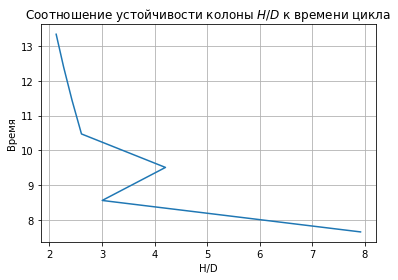

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(df['hd'], df['tcph'])
plt.ylabel('Время')
plt.xlabel('H/D')
plt.grid()
plt.title('Соотношение устойчивости колоны $H/D$ к времени цикла')
plt.show()

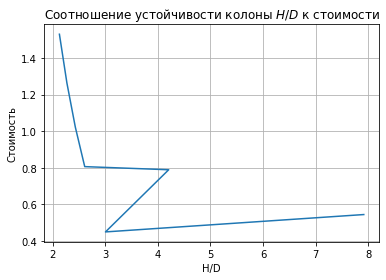

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(df['hd'], df['Stoim'])
plt.ylabel('Стоимость')
plt.xlabel('H/D')
plt.grid()
plt.title('Соотношение устойчивости колоны $H/D$ к стоимости')
plt.show()

График Стоимость - время цикла

C:\Users\huawei\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


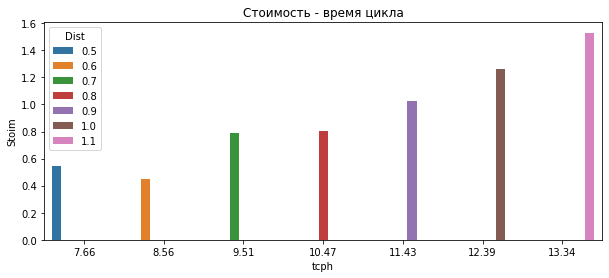

In [45]:
plt.figure(figsize=(10,4))
sns.barplot(np.round(df['tcph'], 2), df['Stoim'], hue=np.round(df['Dist'], 2))
plt.title('Стоимость - время цикла')
plt.show()

In [11]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

C:\Users\huawei\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


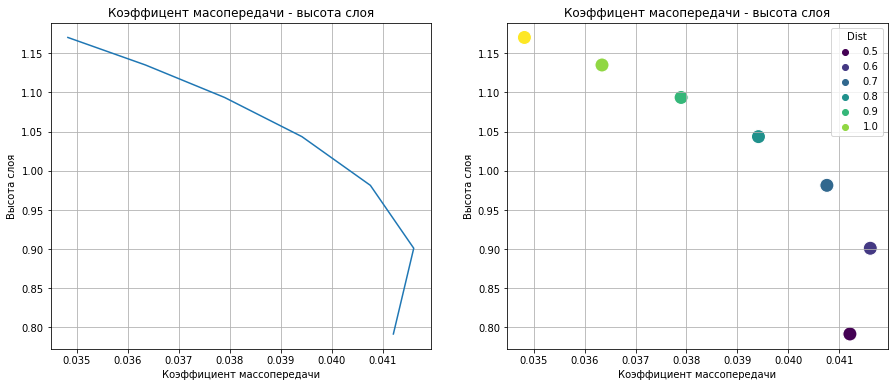

In [44]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(df['Kist'], df['Hist'])
plt.ylabel('Высота слоя')
plt.xlabel('Коэффициент массопередачи')
plt.grid()
plt.title('Коэффицент масопередачи - высота слоя')

plt.subplot(1, 2, 2)
sns.scatterplot(df['Kist'], df['Hist'], hue=df['Dist'], palette='viridis', s=200)
plt.ylabel('Высота слоя')
plt.xlabel('Коэффициент массопередачи')
plt.grid()
plt.title('Коэффицент масопередачи - высота слоя')

plt.show()

1. Внимательнее рассмотреть случай с колонной $Dist=0.6$:

она по многим показателям выделяется своей чрезвычайной эффективностью по сравнению с другими диаметрами.

Это выглядит подозрительно.

2. Рекомендую подробно расписать комментарии ко всем переменным в расчётах (написать правильные названия).